In [1]:
!pip install easydict
!pip install dgl

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
DataPath = "./Datasets/TerrorAttack/"

ListX1 = []
ListX2 = []

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import torch
import os
#import spicy as sp

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


print(os.listdir(DataPath))


from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        #fea1=[]
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
# Any results you write to the current directory are saved as output.

['.DS_Store', 'terrorist_attack_loc.edges', 'README', 'terrorist_attack.labels', 'terrorist_attack.nodes', 'terrorist_attack_loc_org.edges']


In [3]:
from __future__ import print_function
from __future__ import division

In [4]:
import torch.nn as nn
import torch.nn.functional as F
ListX1 = []
ListX2 = []

def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                         dtype=np.int32)
    print(labels_onehot)
    return labels_onehot


class GCN(nn.Module):
    
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        
        print("Hidden Layers", nhid)
        self.gc1 = GraphConvolution(nfeat, nhid)
        
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout
 
    #fea2=[]
    #fea1=[]
    def forward(self, x, adj):
        x1 = self.gc1(x, adj)
        ListX1.append(x1)
        #print("X1 matrix - ", x1)
        
        fea1.append(x1)
        
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x2 = self.gc2(x, adj)
        ListX2.append(x2)
        #fea2.append(x2)
        
        x = self.gc2(x, adj)
        #fea2.append(x2)
        return F.log_softmax(x, dim=1)

In [8]:
import scipy.sparse as sp
def load_karate(path="./Datasets/Karate Dataset/"):
    """Load karate club dataset"""
    print('Loading karate club dataset...')

    edges = np.loadtxt("{}edges.txt".format(path), dtype=np.int32)  - 1# 0-based indexing
    features = sp.eye(np.max(edges+1), dtype=np.float32).tocsr()
    idx_labels = np.loadtxt("{}mod-based-clusters.txt".format(path), dtype=np.int32)
    idx_labels = idx_labels[idx_labels[:, 0].argsort()]
    labels = encode_onehot(idx_labels[:, 1])

    print(np.ones(edges.shape[0]))
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    
    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))
    #print("Normalized Adj matrix=" , adj)
    
    idx_train = range(34) #originally (180)
    idx_val = range(0, 33) #originally (200,500)
    idx_test = range(0, 33) #originally (500,1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)
    #print("Sparce Adj matrix=" , adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    
    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))
    return adj, features, labels, idx_train, idx_val, idx_test

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

all_lab=[]
def accuracy(output, labels):
    all_lab.append(labels)
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [9]:
adj, features, labels, idx_train, idx_val, idx_test  = load_karate()

Loading karate club dataset...
[[0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
Dataset has 34 nodes, 78 edges, 34 features.


In [10]:
#print(features.cpu().numpy())
import seaborn as sns
A = features.cpu().numpy()
sns.heatmap(A, cmap="YlGnBu")

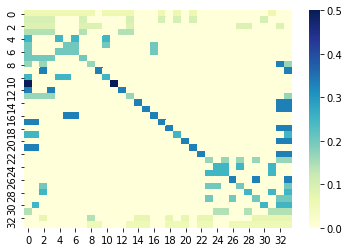

In [11]:
A = adj.to_dense().numpy()
X = features.cpu().numpy()
X0 = np.matmul(A,X)

sns.heatmap(X0, cmap="YlGnBu") 

In [12]:
import csv
print(X0)

[[0.05882353 0.05882353 0.05882353 ... 0.05882353 0.         0.        ]
 [0.1        0.1        0.1        ... 0.         0.         0.        ]
 [0.09090909 0.09090909 0.09090909 ... 0.         0.09090909 0.        ]
 ...
 [0.14285715 0.         0.         ... 0.14285715 0.14285715 0.14285715]
 [0.         0.         0.07142857 ... 0.07142857 0.07142857 0.07142857]
 [0.         0.         0.         ... 0.05555556 0.05555556 0.05555556]]


In [13]:
#with open("./Heatmap dataset/Karate_X0.csv",'w') as resultFile:
#    wr = csv.writer(resultFile, dialect='excel')
#    wr.writerows(X0)

[[ 0 31]
 [ 0 21]
 [ 0 19]
 [ 0 17]
 [ 0 13]
 [ 0 12]
 [ 0 11]
 [ 0 10]
 [ 0  8]
 [ 0  7]
 [ 0  6]
 [ 0  5]
 [ 0  4]
 [ 0  3]
 [ 0  2]
 [ 0  1]
 [ 1 30]
 [ 1 21]
 [ 1 19]
 [ 1 17]
 [ 1 13]
 [ 1  7]
 [ 1  3]
 [ 1  2]
 [ 2 13]
 [ 2  8]
 [ 2  9]
 [ 2 32]
 [ 2 28]
 [ 2 27]
 [ 2  7]
 [ 2  3]
 [ 3 13]
 [ 3 12]
 [ 3  7]
 [ 4 10]
 [ 4  6]
 [ 5 16]
 [ 5 10]
 [ 5  6]
 [ 6 16]
 [ 8 33]
 [ 8 32]
 [ 8 32]
 [ 9 33]
 [13 33]
 [14 33]
 [14 32]
 [15 33]
 [15 32]
 [18 33]
 [18 32]
 [19 33]
 [20 33]
 [20 32]
 [22 33]
 [22 32]
 [23 29]
 [23 33]
 [23 32]
 [23 27]
 [23 25]
 [24 31]
 [24 27]
 [24 25]
 [25 31]
 [26 33]
 [26 29]
 [27 33]
 [28 33]
 [28 31]
 [29 33]
 [29 32]
 [30 33]
 [30 32]
 [31 33]
 [31 32]
 [32 33]]
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 8, 8, 8, 9, 13, 14, 14, 15, 15, 18, 18, 19, 20, 20, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 26, 26, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32) (31, 21, 19, 17, 13, 12, 11, 

/Users/mridulag/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


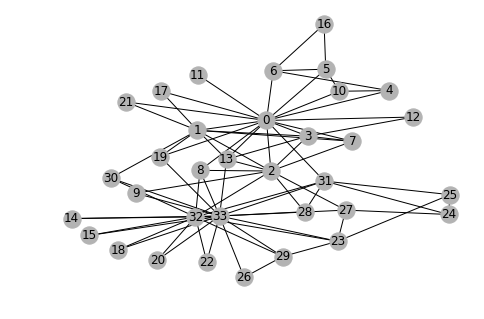

In [17]:
import dgl
import networkx as nx

g = dgl.DGLGraph()
g.add_nodes(34)
DataPath = "./Datasets/Karate Dataset/"
#idx_features_labels = np.genfromtxt(DataPath+"terrorist_attack.nodes",
                                       # np.dtype(str),comments=None)

#features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
#print(features)

#labels = encode_onehot(idx_features_labels[:, -1])
#print(labels)

#build graph
#idx = np.array(idx_features_labels[:, 0], dtype=None)
#print(idx)
#idx_map = {j: i for i, j in enumerate(idx)}

edges_unordered = np.genfromtxt(DataPath+"edges.txt",
                                np.dtype(str),comments=None);
edges = np.array((edges_unordered.flatten()),dtype=np.int32).reshape(edges_unordered.shape) - 1
print(edges)
src, dst = tuple(zip(*edges));
g.add_edges(src, dst);
g.add_edges(dst, src);

print(src, dst)
print('We have %d nodes.' % g.number_of_nodes())
print('We have %d edges.' % g.number_of_edges())
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = g.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
#print("pos: ",pos)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [18]:
print(idx_train)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])


In [19]:
from __future__ import division
from __future__ import print_function
import time
import argparse
import numpy as np
import easydict
import torch
import torch.nn.functional as F
import torch.optim as optim


# Training settings
# parser = argparse.ArgumentParser()
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='Disables CUDA training.')
# parser.add_argument('--fastmode', action='store_true', default=False,
#                     help='Validate during training pass.')
# parser.add_argument('--seed', type=int, default=42, help='Random seed.')
# parser.add_argument('--epochs', type=int, default=200,
#                     help='Number of epochs to train.')
# parser.add_argument('--lr', type=float, default=0.01,
#                     help='Initial learning rate.')
# parser.add_argument('--weight_decay', type=float, default=5e-4,
#                     help='Weight decay (L2 loss on parameters).')
# parser.add_argument('--hidden', type=int, default=16,
#                     help='Number of hidden units.')
# parser.add_argument('--dropout', type=float, default=0.5,
#                     help='Dropout rate (1 - keep probability).')

args = easydict.EasyDict({
        "no_cuda": False,
        "fastmode": False,
        "seed": 42,
        "epochs": 200,
        "lr": 0.01,
        "weight_decay": 5e-4,
        "hidden": 16, #hidden layer 
        "dropout": 0.5
})
args.cuda = not args.no_cuda and torch.cuda.is_available()
#print(args.no_cuda,torch.cuda.is_available(),args.cuda)
np.random.seed(args.seed)
#print(np.random.seed(args.seed))
#print(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_karate()

# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=args.hidden,
            nclass=labels.max().item() + 1,
            dropout=args.dropout)

print("model is..d",model)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

all_logits = []
all_labels=[]
fea1=[]
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    print("log",output)
    all_logits.append(output.detach())
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    all_labels.append(labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    #print('Epoch: {:04d}'.format(epoch+1),
    #      'loss_train: {:.4f}'.format(loss_train.item()),
    #      'acc_train: {:.4f}'.format(acc_train.item()),
    #      'loss_val: {:.4f}'.format(loss_val.item()),
    #      'acc_val: {:.4f}'.format(acc_val.item()),
    #      'time: {:.4f}s'.format(time.time() - t))

print(all_logits)
print("Eval is -", model.eval())
print("feature size are",features.size())
#print("features are",features)
print("Model is -", model(features, adj).size())
print("Model Test is -", model(features, adj)[idx_test].size())

def test():
    model.eval()
    output = model(features, adj)
    #print("Output2 is -", output)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))


# Train model
t_total = time.time()
list_weights = []

for epoch in range(args.epochs):
    train(epoch)
    parameterlist = list(model.parameters())
    w0 = parameterlist[0].detach().numpy()
    list_weights.append(w0)
    #w1 = parameterlist[2].detach().numpy()
   
print("Model Parameters -", list(model.parameters()))
parameterlist = list(model.parameters())
#w0 = parameterlist[0].detach().numpy()
#w1 = parameterlist[2].detach().numpy()


print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))



import seaborn as sns

# Testing
test()

Loading karate club dataset...
[[0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
Dataset has 34 nodes, 78 edges, 34 features.
Hidden Layers 16
model is..d GCN(
  (gc1): GraphConvolution (34 -> 16)
  (gc2): GraphConvolution (16 -> 4)
)
[]
Eval is - GCN(
  (gc1): GraphConvolution (34 -> 16)
  (gc2): GraphConvolution (16 -> 4)
)
feature size are torch.Size([34, 34])
Model is - torch.Size([34, 4])
Model Test is - torch.Size([33, 4])
log

log tensor([[-3.1586, -0.0952, -3.1736, -5.0475],
        [-4.9831, -0.0474, -3.3071, -5.8640],
        [-3.9217, -0.8412, -0.7121, -2.8410],
        [-5.3225, -0.0357, -3.5203, -7.4844],
        [-0.3254, -1.3797, -4.1163, -4.6259],
        [-0.1479, -2.1078, -4.6059, -5.1147],
        [-0.1753, -1.9766, -4.4754, -4.5262],
        [-5.4067, -0.0650, -2.8550, -6.9785],
        [-3.4689, -4.3809, -1.1069, -0.4688],
        [-3.8693, -2.9754, -0.5667, -1.0196],
        [-0.2074, -1.8057, -4.7668, -4.2375],
        [-3.6631, -0.0351, -5.2892, -5.5749],
        [-5.3083, -0.0155, -4.5721, -9.0274],
        [-3.7188, -0.1877, -1.9818, -4.7052],
        [-6.0712, -9.1956, -4.2520, -0.0168],
        [-4.7054, -7.0022, -2.8745, -0.0687],
        [-0.0418, -3.4446, -5.4114, -5.3980],
        [-3.9301, -0.0222, -6.1154, -8.8014],
        [-5.8128, -9.5573, -3.8044, -0.0257],
        [-3.5708, -0.1819, -2.0596, -4.5364],
        [-3.7763, -6.8727, -2.5285, -0.1095],
        [-6.1624, -0.0041, -6.

log tensor([[ -2.5757,  -0.1437,  -3.2506,  -3.9654],
        [ -5.2859,  -0.0267,  -3.9172,  -6.6041],
        [ -5.3954,  -1.3100,  -0.3988,  -2.9087],
        [ -7.8803,  -0.0162,  -4.1690,  -8.3835],
        [ -0.0615,  -3.3004,  -5.7570,  -3.9309],
        [ -0.0455,  -3.2803,  -5.9951,  -5.4432],
        [ -0.0138,  -4.3822,  -8.4975,  -6.9510],
        [ -7.2530,  -0.0204,  -3.9471,  -8.5897],
        [ -3.4351,  -4.2511,  -3.7847,  -0.0717],
        [ -7.5034,  -4.3413,  -0.0486,  -3.3844],
        [ -0.0786,  -2.6550,  -6.2259,  -5.7156],
        [ -7.6329,  -0.0012,  -7.4743,  -8.8831],
        [ -7.9362,  -0.0283,  -3.6205,  -7.1847],
        [ -6.5212,  -0.0956,  -2.4431,  -5.8695],
        [ -5.2288,  -8.5794,  -6.6803,  -0.0068],
        [ -6.2463,  -9.5314,  -8.8885,  -0.0022],
        [ -0.0016,  -6.7222, -10.0989,  -7.9175],
        [ -4.7289,  -0.0098,  -7.0085, -10.8526],
        [ -7.9007, -12.7139,  -8.9458,  -0.0005],
        [ -4.2637,  -0.0589,  -4.4381,  -3.463

In [20]:
import csv

DF_X1_Epochs = pd.DataFrame()
DF_X1  = pd.DataFrame()
i = 0
while i <= 200: 
    X1 = ListX1[i].detach().numpy()
    DF_X1 = pd.DataFrame(X1)
    DF_X1["Epochs"] = i
    #DF_X1_Epochs.append(DF_X1)
    DF_X1_Epochs = pd.concat([DF_X1_Epochs,DF_X1])
    i = i + 10
print(DF_X1_Epochs)

#with open("Heatmap dataset/Karate_X1_Epochs.csv", 'w+') as f:
#    DF_X1_Epochs.to_csv(f, header=True)

           0         1         2         3         4         5         6  \
0   0.311727  0.067075  0.151529  0.154817  0.139200 -0.082910 -0.039865   
1   0.310160  0.064199  0.081273  0.233778  0.105236 -0.095083 -0.045549   
2   0.329866  0.000595  0.095594  0.227404  0.149790 -0.100148 -0.062392   
3   0.357996  0.052296  0.068581  0.240843  0.130257 -0.080194 -0.086055   
4   0.416230  0.055254  0.167869  0.098872  0.141304 -0.104767 -0.067010   
5   0.366868 -0.009525  0.173443  0.150022  0.249296 -0.121477 -0.045201   
6   0.336741 -0.030929  0.208481  0.164450  0.198487 -0.143797  0.022678   
7   0.391429  0.003857  0.011166  0.247668  0.145096 -0.044683 -0.102241   
8   0.369113 -0.000486  0.116019  0.181735  0.231188 -0.054753  0.007748   
9   0.303121  0.067195  0.183548  0.272738  0.280067 -0.005908  0.030156   
10  0.326724  0.033736  0.223187  0.134084  0.215028 -0.135211 -0.023007   
11  0.237440  0.172085  0.212262  0.191202  0.203471  0.003460 -0.094105   
12  0.394555

In [21]:
import csv

DF_X2_Epochs = pd.DataFrame()
DF_X2  = pd.DataFrame()
i = 0
while i <= 200: 
    X2 = ListX2[i].detach().numpy()
    DF_X2 = pd.DataFrame(X2)
    DF_X2["Epochs"] = i
    #DF_X1_Epochs.append(DF_X1)
    DF_X2_Epochs = pd.concat([DF_X2_Epochs,DF_X2])
    i = i + 10
print(DF_X2_Epochs)

#with open("Heatmap dataset/Karate_X2_Epochs.csv", 'w+') as f:
#    DF_X2_Epochs.to_csv(f, header=True)
    

           0         1         2         3  Epochs
0  -0.035402 -0.138894 -0.107147 -0.044638       0
1  -0.018209 -0.137644 -0.077340 -0.013040       0
2  -0.023422 -0.156912 -0.078116 -0.030150       0
3  -0.007196 -0.111504 -0.067864 -0.007076       0
4  -0.056234 -0.162596 -0.163028 -0.084866       0
5  -0.051061 -0.179977 -0.137566 -0.085828       0
6  -0.040780 -0.197416 -0.152900 -0.073878       0
7  -0.006199 -0.122513 -0.065007 -0.007779       0
8  -0.018089 -0.181496 -0.064287 -0.027581       0
9  -0.048662 -0.167337 -0.074327 -0.048041       0
10 -0.040084 -0.144159 -0.147796 -0.087502       0
11 -0.132226 -0.205221 -0.176791 -0.093840       0
12 -0.017825 -0.103529 -0.093449 -0.021450       0
13 -0.027949 -0.158760 -0.067556 -0.008985       0
14 -0.055105 -0.246674 -0.051041 -0.011148       0
15 -0.020798 -0.220804 -0.061393 -0.008445       0
16 -0.042561 -0.208440 -0.138232 -0.082537       0
17 -0.053470 -0.167299 -0.119123 -0.069670       0
18 -0.013315 -0.208469 -0.07814

In [22]:
len(fea1)

403

iteration -  0


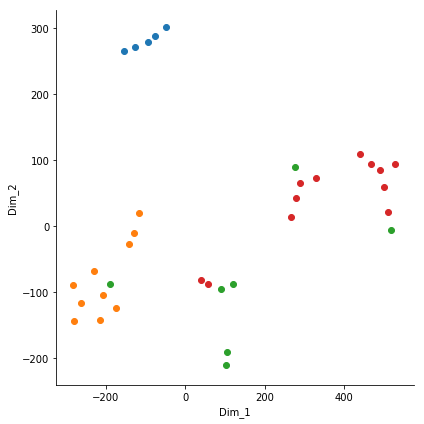

iteration -  10


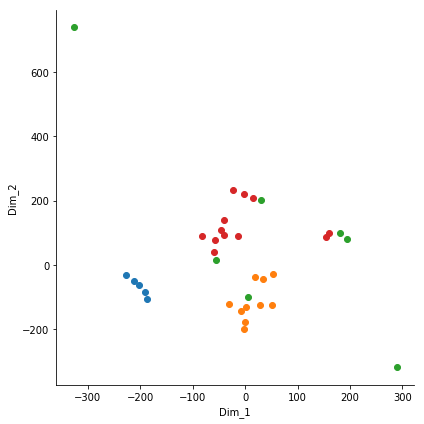

iteration -  20


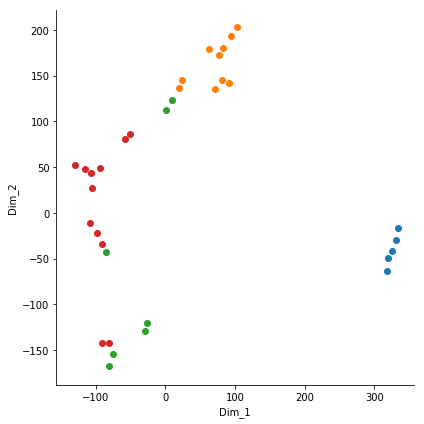

iteration -  30


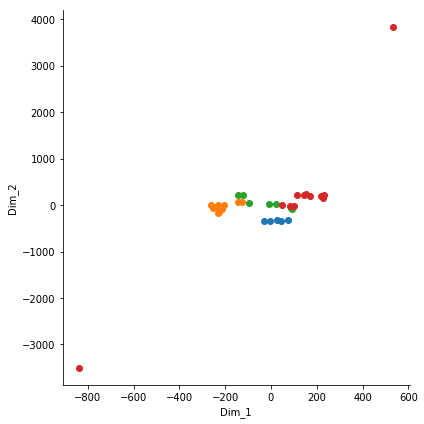

iteration -  40


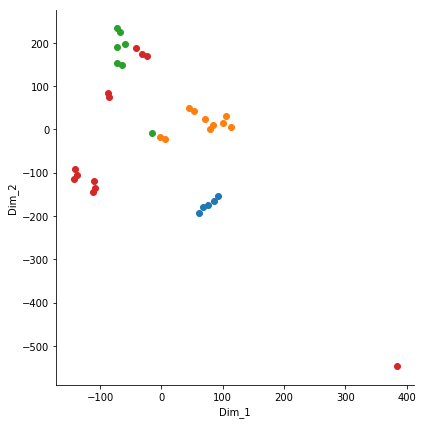

iteration -  50


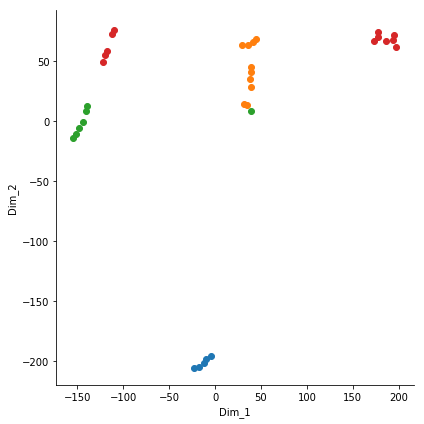

iteration -  60


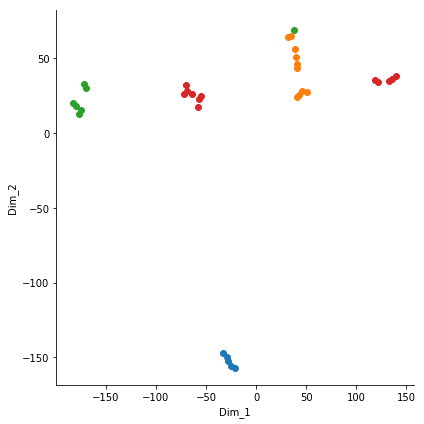

iteration -  70


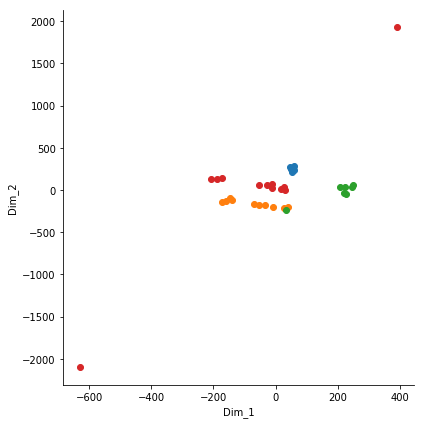

iteration -  80


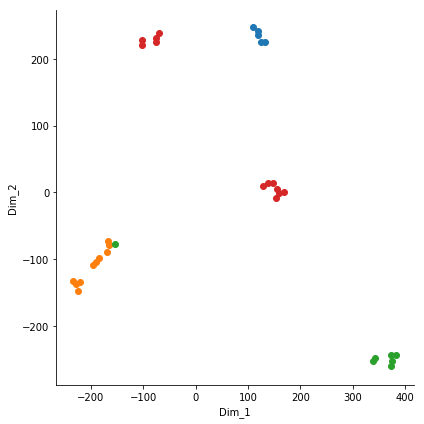

iteration -  90


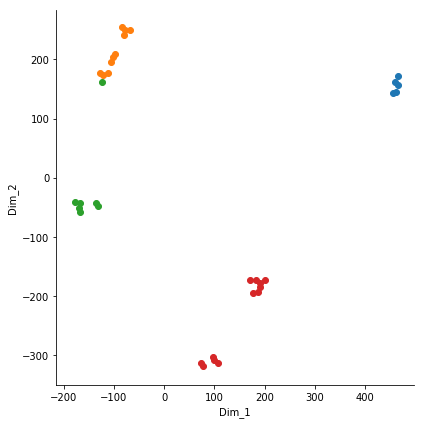

iteration -  100


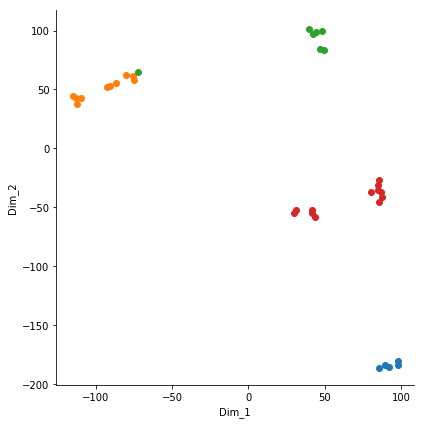

iteration -  110


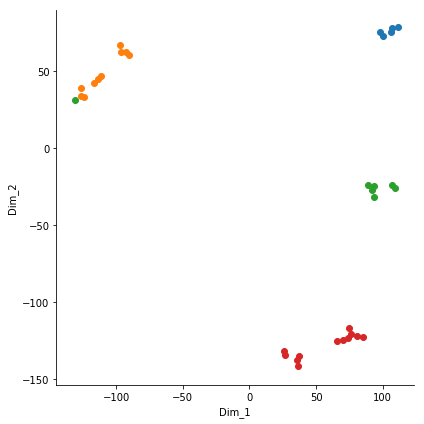

iteration -  120


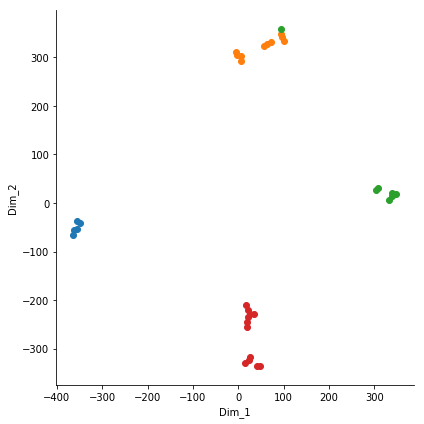

iteration -  130


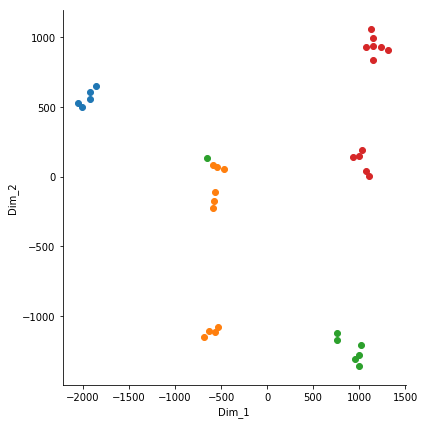

iteration -  140


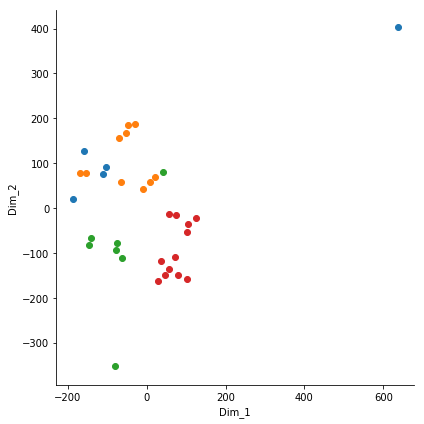

iteration -  150


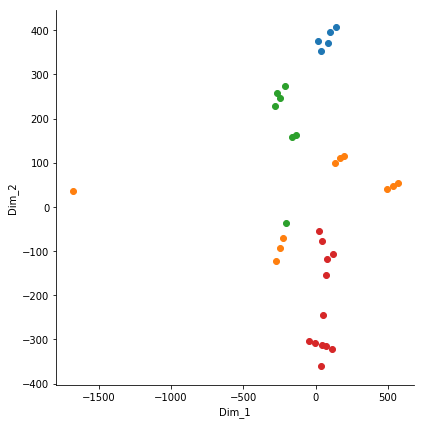

iteration -  160


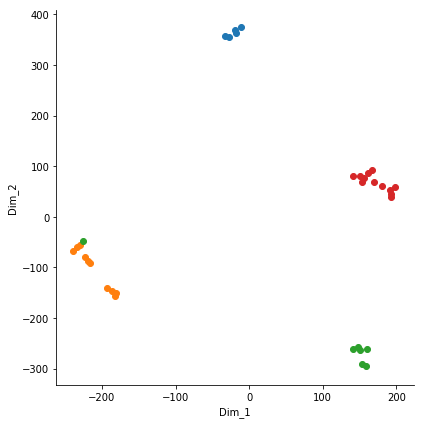

iteration -  170


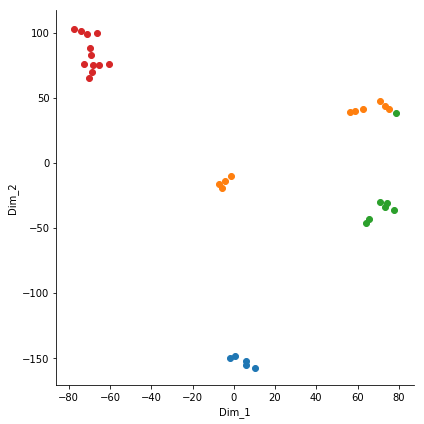

iteration -  180


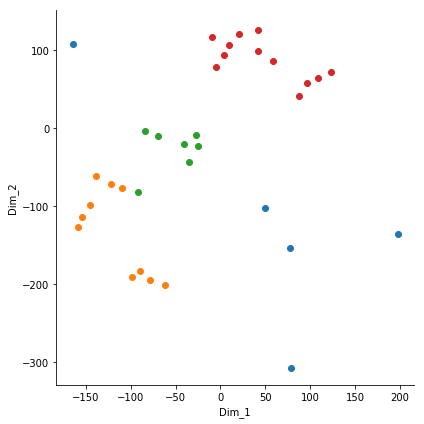

iteration -  190


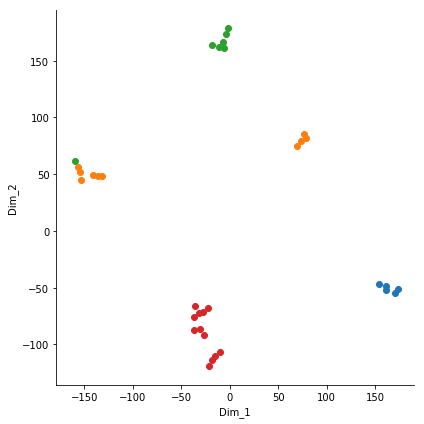

iteration -  200


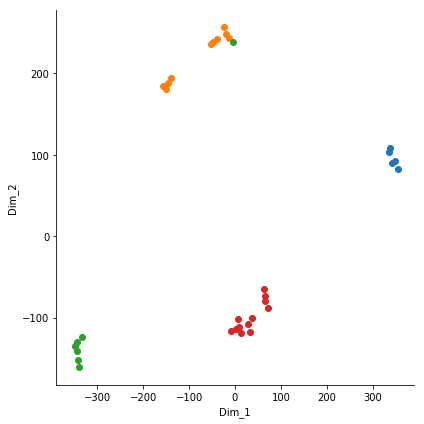

In [23]:
from sklearn.manifold import TSNE
import csv
from matplotlib import pyplot as plt
i = 0

#with open("./tSNE dataset/Karate_tsne_epochs.csv", 'w+') as f:
#    writer = csv.writer(f, delimiter=',')
#    writer.writerow(["NodeID","Group","Dim_1","Dim_2","Epochs"])

while i<=200:
    output=fea1[i].detach().numpy()
    md=TSNE(n_components=2,random_state=0,perplexity = 2,learning_rate  = 100, n_iter=5000) #Define TSNE model
    tsne_data=md.fit_transform(output) #Apply TSNE on the 190 iter
    tsne_data=np.vstack((labels,tsne_data.T)).T #Stack 
    tsne_df=pd.DataFrame(data=tsne_data,columns=["label","Dim_1","Dim_2"])
    tsne_df["Epochs"] = i
    #print(tsne_df)
#    with open("./tSNE dataset/Karate_tsne_epochs.csv", 'a+') as f:
#        tsne_df.to_csv(f, header=False)
    print("iteration - ", i)
    i = i+10
    sns.FacetGrid(tsne_df,hue="label",height=6).map(plt.scatter,"Dim_1","Dim_2")
    plt.show()

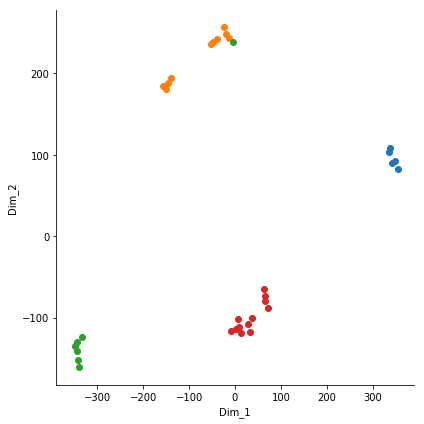

In [24]:
sns.FacetGrid(tsne_df,hue="label",height=6).map(plt.scatter,"Dim_1","Dim_2")
plt.show()

In [26]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
outp=fea1[10].detach().numpy()
data_1000=outp
labels_1000=labels
print(labels)
md=TSNE(n_components=2,random_state=0,perplexity = 30,learning_rate  = 100, n_iter=5000)

tsne_data=md.fit_transform(data_1000)

tsne_data=np.vstack((labels_1000,tsne_data.T)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=["label","Dim_1","Dim_2"])
#print(tsne_df)
#export_csv = tsne_df.to_csv ('files.csv', index = None, header=True)

tensor([1, 1, 2, 1, 0, 0, 0, 1, 3, 2, 0, 1, 1, 1, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3,
        2, 2, 3, 2, 2, 3, 3, 2, 3, 3])


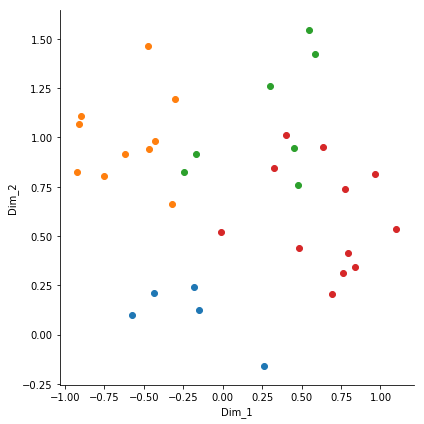

In [27]:
sns.FacetGrid(tsne_df,hue="label",height=6).map(plt.scatter,"Dim_1","Dim_2")
plt.show()

In [28]:
print(list_weights[1].shape)

(34, 16)


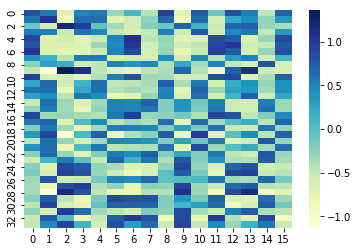

In [29]:
import matplotlib.pyplot as plt

#fig,ax = plt.subplots(1,2)

#sns.heatmap(data = list_weights[1])
#sns.palplot(sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0))
sns.heatmap(list_weights[0], cmap="YlGnBu")
#sns.heatmap(data = list_weights[1],ax=[1,0])

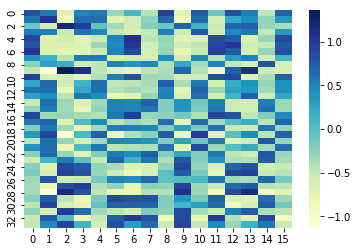

In [30]:
sns.heatmap(list_weights[1], cmap="YlGnBu")

In [ ]:
#print("0 = ", list_weights[0])
#print("1 = ", list_weights[1])

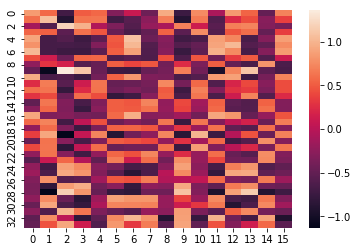

In [31]:
sns.heatmap(w0)
#print(w0)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


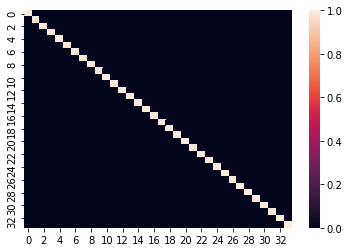

In [32]:
import seaborn as sns
import numpy as np
print(features.cpu().numpy())
A = features.cpu().numpy()
sns.heatmap(A)